In [1]:
from fastai.text import *
from fastai.callbacks import *

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from dataclasses import dataclass

In [2]:
pretrained_weights = 'roberta-base'
use_fp16 = True
bs = 32
pad_first = cls_last = False # except for XLNet
use_fast_tokenizer = True # except for SentencePiece (e.g., XLNet)

root_dir = Path('/')
data_dir = root_dir / 'data' / 'jigsaw_unintended_toxicity'
model_dir = (Path('.') / 'models' / pretrained_weights).absolute()
pretrained_model_dir = root_dir / 'models' / 'transformers'

data_dir, model_dir, pretrained_model_dir

(PosixPath('/data/jigsaw_unintended_toxicity'),
 PosixPath('/volume/models/roberta-base'),
 PosixPath('/models/transformers'))

In [3]:
def seed_all(seed_value: int):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed_value)

seed = 777 # used again later in train/test split
seed_all(seed)

In [4]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    for col in progress_bar(df.columns):
        col_type = df[col].dtype
        
        if col_type == object:
            df[col] = df[col].astype('category')
        else:
            c_min = df[col].min()
            c_max = df[col].max() 
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

In [5]:
train_df = pd.read_csv(data_dir / 'train.csv')
train_df = reduce_mem_usage(train_df)
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893555,haha you guys are a bunch of losers.,0.021271,0.0,0.021271,0.872559,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
@dataclass
class TransformersBaseTokenizer(BaseTokenizer):
    pretrained_tokenizer: object
        
    def __call__(self, *args, **kwargs):
        return self
    
    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens"""
        CLS, SEP = self.pretrained_tokenizer.cls_token, self.pretrained_tokenizer.sep_token
        tokens = self.pretrained_tokenizer.tokenize(t)[:self.pretrained_tokenizer.max_len - 2]
        return tokens + [SEP] + [CLS] if cls_last else [CLS] + tokens + [SEP]
    
class TransformersVocab(Vocab):
    def __init__(self, tokenizer):
        super().__init__(itos=[])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [7]:
def load_or_download_pretrained(cls, pretrained_model_dir: Path, pretrained_weights: str, **kw_args):
    cache_dir = str(pretrained_model_dir / pretrained_weights)
    try:
        ret = cls.from_pretrained(cache_dir, **kw_args)
    except:
        ret = cls.from_pretrained(pretrained_weights, **kw_args)
        ret.save_pretrained(cache_dir)
    return ret

In [8]:
pretrained_tokenizer = load_or_download_pretrained(AutoTokenizer, 
                                                    pretrained_model_dir, 
                                                    pretrained_weights,
                                                    use_fast=use_fast_tokenizer,
                                                   )
pretrained_tokenizer

In [9]:
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer=pretrained_tokenizer)
fastai_tokenizer = Tokenizer(tok_func=transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [10]:
transformer_vocab = TransformersVocab(tokenizer=pretrained_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

In [11]:
tokens = pretrained_tokenizer.tokenize('Salut c est moi, Hello it s me')
ids = pretrained_tokenizer.convert_tokens_to_ids(tokens)
tokens, ids, pretrained_tokenizer.convert_ids_to_tokens(ids)

(['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme'],
 [18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162],
 ['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme'])

In [12]:
databunch = (TextList.from_df(train_df, cols='comment_text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'target')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pretrained_tokenizer.pad_token_id))

/opt/conda/lib/python3.8/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [13]:
databunch.show_batch()

/opt/conda/lib/python3.8/site-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
"<s> "" ðĿ Ļ ı ðĿ Ļ Ŀ ðĿ Ļ ļ Ġ ðĿ Ļ Ĺ ðĿ Ļ ŀ ðĿ Ļ ľ Ġ ðĿ Ļ ¥ ðĿ Ļ § ðĿ Ļ ¤ ðĿ Ļ Ĺ ðĿ Ļ ¡ ðĿ Ļ ļ ðĿ Ļ ¢ Ġ ðĿ Ļ ŀ ðĿ Ļ ¨ Ġ ðĿ Ļ ĸ ðĿ Ļ ¡ ðĿ Ļ ¡ ðĿ Ļ ĸ ðĿ Ļ ® ðĿ Ļ ŀ ðĿ",0.0
<s> A : Ġ($ 10 . 36 Ġmil Ġ( U AA ĠAthletics )) Ġ/ Ġ($ 377 Ġmil Ġ( UA ĠBudget )) Ġ= Ġ2 . 7 %. Ġ Ċ Maybe Ġyou Ġshould Ġgo Ġback Ġto Ġschool . Ċ Ċ B : ĠHere Ġare Ġmy Ġschool Ġfees . Ċ Ċ - Sch Ġof ĠBus Ġ1 ĠTime ĠSem ester ĠLab ĉ $ 34 . 00 Ċ - A th let ic / Rec,0.0
"<s> Let 's Ġsee . ĠWe Ġneed Ġfunding Ġfor Ġthe Ġport . ĠLike , ĠNow . ĠHow Ġabout Ġthese : Ċ Close Ġthe ĠSp en ard ĠL IO , Ġsell Ġit Ġoff Ġfor Ġat Ġleast Ġ$ 10 Ġmillion . ĠWe 'll Ġlose Ġ$ 2 Ġmillion , Ġbut Ġit 's Ġa Ġquicker Ġsale Ġand Ġwe Ġcan Ġpenal ize Ġour Ġso - called Ġ' rep rest atives ' Ġover Ġ10 Ġyears Ġto",0.19995117
"<s> When ĠI Ġfirst Ġread Ġabout Ġthe ĠKh adr Ġsettlement Ġyesterday , Ġthe Ġfirst Ġthing Ġthat Ġimmediately Ġcame Ġto Ġmind Ġwas Ġa Ġscene Ġfrom Ġthe Ġexcellent , Ġunderrated Ġ90 s Ġflick , ĠA ĠBronx ĠTale . Ċ In Ġit , Ġthe Ġlocal Ġmafia Ġboss , ĠSonny Ġ( Ch azz ĠPal min ter i ) Ġwatches Ġas ĠCal og ero Ġ( a . k . a ."" C ,"" Ġplayed Ġby",0.0
"<s> T err ified Ġby ĠTrump 's Ġwords Ġand Ġactions Ġand Ġthose Ġof Ġsome Ġof Ġhis Ġsupporters , Ġeh ? Ġ ĠWhat Ġabout Ġthe Ġwords Ġand Ġactions Ġof Ġthose Ġwho Ġclearly Ġdidn 't Ġsupport ĠTrump ? Ġ Ġ Ċ Ċ http :// w reg . com / 2016 / 12 / 21 / miss iss ippi - author ities - make - ar rest - in - burning - of",0.0


In [14]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model):
        super().__init__() # required by Pytorch
        self.transformer_model = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=pretrained_tokenizer.pad_token_id).type(input_ids.type())
        return self.transformer_model(input_ids, attention_mask=attention_mask)[0]

In [15]:
config = load_or_download_pretrained(AutoConfig, pretrained_model_dir, pretrained_weights)
config.num_labels = 1
config.use_bfloat16 = use_fp16
config

RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "use_bfloat16": true,
  "vocab_size": 50265
}

In [16]:
transformer_model = load_or_download_pretrained(
    AutoModelForSequenceClassification, 
    pretrained_model_dir, 
    pretrained_weights, 
    config=config)

custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

In [17]:
learner = Learner(databunch, 
                  custom_transformer_model, 
                  metrics=[accuracy],
                  model_dir=model_dir,
                 )

learner.callbacks.append(ShowGraph(learner))

if use_fp16: 
    learner = learner.to_fp16()

# Fine tune top layers

In [18]:
m = learner.model.transformer_model.roberta
list_layers = [m.embeddings] + list(m.encoder.layer) + [m.pooler]

learner.split(list_layers)
num_groups = len(learner.layer_groups)

epoch,train_loss,valid_loss,accuracy,time


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.31E-07


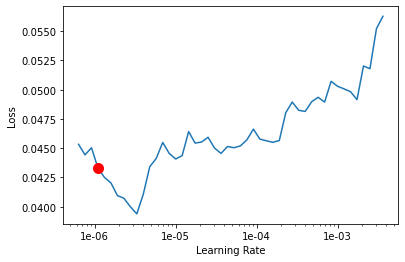

In [19]:
learner.freeze_to(-1)
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.029136,0.029445,0.700710,23:52


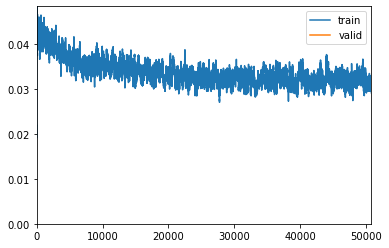

In [20]:
learner.fit_one_cycle(1,max_lr=4e-05) # <2.4GB VRAM
learner.save('stage_1')

epoch,train_loss,valid_loss,accuracy,time


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-06


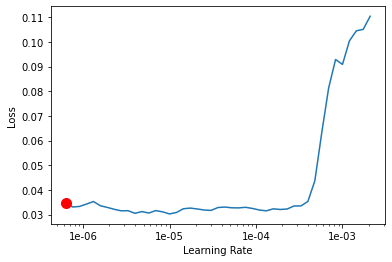

In [21]:
learner.freeze_to(-2)
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.019470,0.016348,0.700710,32:19


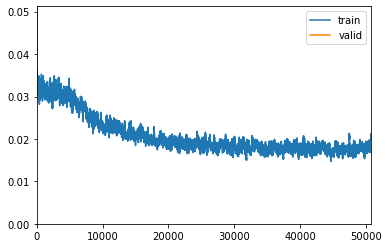

In [22]:
lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr)) # <3GB VRAM
learner.save('stage_2')

epoch,train_loss,valid_loss,accuracy,time


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 9.12E-08


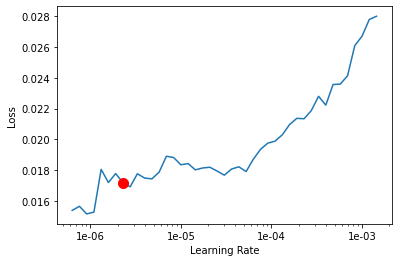

In [23]:
learner.freeze_to(-3)
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.014792,0.014446,0.700710,38:14


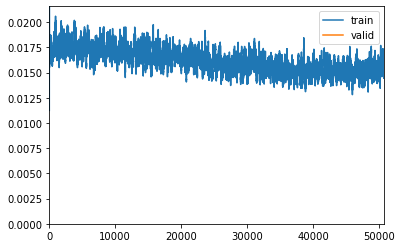

In [24]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr))  # ~4GB VRAM
learner.save('stage_3')

# Fine tune all layers

In [ ]:
# learner.load('stage_3')
# learner.unfreeze()
# learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr)) # >11GB VRAM
# learner.save('stage_4')